In [7]:
'''
#Gigacow-tools# - preprocessing
This scripts used for single cow data collection work.
Data Tables: gigacow_filter.csv, lactation_filter.csv, traffic_raw_filter.csv
'''

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#access data from local directory
dataDir = "C:/Users/Savior_Hn/Desktop/Gigacow/"
gigacow_cols = ['AnimalNumber', 'FarmName_Pseudo', 'BreedName', 'Age']
lactation_cols = ['AnimalNumber', 'FarmName_Pseudo', 'LactationInfoDate', 'LactationNumber', 'DaysInMilk']
gigacow = pd.read_csv(dataDir + 'gigacow_filter.csv', encoding='utf-8', usecols=gigacow_cols)
lactation = pd.read_csv(dataDir + 'lactation_filter.csv', encoding='utf-8', usecols=lactation_cols)
traffic = pd.read_csv(dataDir + 'traffic_raw_filter.csv', encoding='utf-8', index_col=False)
#check out cows with most milking events
print(traffic.Gigacow_Cow_Id.value_counts().nlargest(10))

2022    9107
1535    8929
1095    8630
2724    8594
3046    8570
2197    8255
3726    8023
5661    7909
5533    7870
2053    7819
Name: Gigacow_Cow_Id, dtype: int64


In [85]:
#select single cow from the traffic table
traffic_single_cow = traffic.loc[traffic['Gigacow_Cow_Id'] == 2053]
traffic_single_cow.sort_values(by='TrafficEventDateTime', inplace=True)
traffic_single_cow.index = range(len(traffic_single_cow))

'''
    Extract Milking Event and its most recent traffic event to calculate T2-T1
    T1: Entry time into the Mjolkfalla
    T2: Entry time into the milking robot
    T2-T1: calculate time difference between T2&T1 (i.e., Time spend in Mjolkfalla/holding area)
'''
# locate mikling event by searching 'kg' keyword in traffic result
# the most recent traffic event to milking event should be pre_milking event
# need to filter out records with gate failure
track_milking = traffic_single_cow.TrafficResult.str.contains('kg', regex=False)
milking_index_list = track_milking.index[track_milking.values == True].tolist()
pre_milking_index_list = [x-1 for x in milking_index_list]
milking_traffic = traffic_single_cow[traffic_single_cow.index.isin(milking_index_list)]
pre_milking_traffic = traffic_single_cow[traffic_single_cow.index.isin(pre_milking_index_list)]

# drop rows that the gate failed to detect cows but have milking result
# previous area in milking_traffic table should only be Mjolkfalla
# previous area in pre_milking_traffic table should not be Mjolkfalla
failed_list_1_milk = milking_traffic.index[milking_traffic['PreviousArea'] == 'Koridor till Sorteringsgrind 2'].tolist()
failed_list_1_pre = [x-1 for x in failed_list_1_milk]
failed_list_2_pre = pre_milking_traffic.index[pre_milking_traffic['PreviousArea'] == 'Mjolkfalla'].tolist()
failed_list_2_milk = [x+1 for x in failed_list_2_pre]
# traffic result in pre_milking_traffic table should contain Mjolkfalla
track_pre_milking = pre_milking_traffic.TrafficResult.str.contains('Mjolkfalla', regex=False)
failed_list_3_pre = track_pre_milking.index[track_pre_milking.values == False].tolist()
failed_list_3_milk = [x+1 for x in failed_list_3_pre]

# remove failed records based on index list
milking_traffic_failed = failed_list_1_milk + failed_list_2_milk + failed_list_3_milk
pre_milking_traffic_failed = failed_list_1_pre + failed_list_2_pre + failed_list_3_pre
milking_traffic.drop(axis=0, index=milking_traffic_failed, inplace=True)
pre_milking_traffic.drop(axis=0, index=pre_milking_traffic_failed, inplace=True)
# concatenate two tables to track the traffic directly
all_milking_traffic = pd.concat([milking_traffic, pre_milking_traffic])
all_milking_traffic.sort_values(by=['TrafficEventDateTime'], inplace=True)
#rename table columns for merging
milking_traffic.rename(columns={"TrafficEventDateTime": "MilkingEventDateTime", "TrafficResult": "MilkProduction", "TimeInArea_totalSeconds": "RoundedSecondsTimeInArea"}, inplace=True)
pre_milking_traffic.rename(columns={"TrafficEventDateTime": "Pre_MilkingEventDateTime", "TimeInArea_totalSeconds": "RoundedSecondsTimeInArea"}, inplace=True)
# unify the index of two tables
milking_traffic.index = range(len(milking_traffic))
pre_milking_traffic.index = range(len(pre_milking_traffic))
# inert "pre_traffic_milking" to milking traffic table
milking_traffic.insert(5, 'Pre_MilkingEventDateTime', pre_milking_traffic['Pre_MilkingEventDateTime'])
# calculate T2-T1
milking_traffic.MilkingEventDateTime = pd.to_datetime(milking_traffic.MilkingEventDateTime)
milking_traffic.Pre_MilkingEventDateTime = pd.to_datetime(milking_traffic.Pre_MilkingEventDateTime)
milking_traffic['timeDelta_Seconds'] = (milking_traffic['MilkingEventDateTime'] - milking_traffic['Pre_MilkingEventDateTime']).dt.total_seconds()

#extract traffic result(milk production)
milking_traffic['MilkProduction'].replace(r"[^0-9.,]+"," ", inplace=True, regex=True)
milking_traffic['MilkProduction'].replace(r"\s*","", inplace=True, regex=True)
milking_traffic['MilkProduction'].replace(r"[,]+",".", inplace=True, regex=True)
milking_traffic['MilkProduction'] = milking_traffic['MilkProduction'].astype('float64')

# merge all the other features into milking_traffic table
milking_traffic['MilkingDate'] = milking_traffic.MilkingEventDateTime.dt.date
milking_traffic.MilkingDate = pd.to_datetime(milking_traffic.MilkingDate)
lactation.LactationInfoDate = pd.to_datetime(lactation.LactationInfoDate)
single_cow_merge = milking_traffic.merge(lactation, how='left', left_on=['FarmName_Pseudo', 'AnimalNumber', 'MilkingDate'], right_on=['FarmName_Pseudo', 'AnimalNumber', 'LactationInfoDate'])
single_cow_merge = single_cow_merge.merge(gigacow, how='left', left_on=['FarmName_Pseudo', 'AnimalNumber'], right_on=['FarmName_Pseudo', 'AnimalNumber'])

# drop failed data points based on RoundedSecondsTimeInArea & timeDelta_Seconds
single_cow_merge.drop(single_cow_merge.loc[abs(single_cow_merge.timeDelta_Seconds - single_cow_merge.RoundedSecondsTimeInArea) > 300].index, inplace=True)

# write the collection result to local directory
single_cow_collection = single_cow_merge[['Gigacow_Cow_Id', 'BreedName', 'Age', 'FarmName_Pseudo', 'GroupName', 'TrafficDeviceName', 'MilkProduction', 'timeDelta_Seconds', 'LactationNumber', 'DaysInMilk']]
single_cow_collection.to_csv(dataDir + 'single_cow_collection.csv')

C:\Users\Savior_Hn\AppData\Local\Temp\ipykernel_25384\2957043043.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traffic_single_cow.sort_values(by='TrafficEventDateTime', inplace=True)
C:\Users\Savior_Hn\AppData\Local\Temp\ipykernel_25384\2957043043.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  milking_traffic.drop(axis=0, index=milking_traffic_failed, inplace=True)
C:\Users\Savior_Hn\AppData\Local\Temp\ipykernel_25384\2957043043.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

<Figure size 432x288 with 0 Axes>

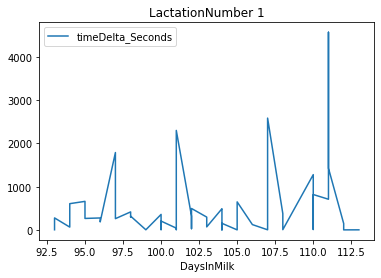

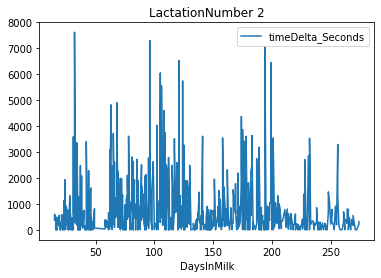

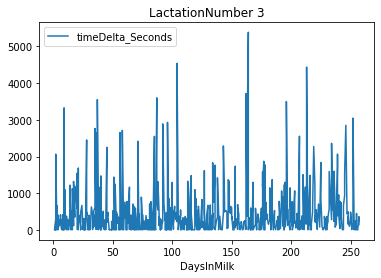

In [87]:
# plot the relations between timeDielta and Lactation/DIM(DaysInMilk)
plt.figure()
single_cow_collection.loc[single_cow_collection.LactationNumber == 1].plot(x="DaysInMilk", y="timeDelta_Seconds", kind='line', title='LactationNumber 1')
single_cow_collection.loc[single_cow_collection.LactationNumber == 2].plot(x="DaysInMilk", y="timeDelta_Seconds", kind='line', title='LactationNumber 2')
single_cow_collection.loc[single_cow_collection.LactationNumber == 3].plot(x="DaysInMilk", y="timeDelta_Seconds", kind='line', title='LactationNumber 3')
plt.show()


In [71]:
single_cow_merge.to_csv(dataDir + 'single_cow_merge.csv')
single_cow_merge

,Traffic_Id,FarmName_Pseudo,AnimalNumber,Gigacow_Cow_Id,GroupName,Pre_MilkingEventDateTime,MilkingEventDateTime,PreviousArea,RoundedSecondsTimeInArea,TrafficDeviceName,MilkProduction,MilkingInterval_totalSeconds,timeDelta_Seconds,MilkingDate,LactationInfoDate,LactationNumber,DaysInMilk,BreedName,Age
0,1344350,a624fb9a,1305,2053,VMS 1,2020-01-16 00:22:05,2020-01-16 00:35:49,Mjolkfalla,824.0,VMS2,8.23,24836.0,824.0,2020-01-16,NaT,NaN,NaN,2,4.68
1,3471317,a624fb9a,1305,2053,VMS 1,2020-01-16 07:05:23,2020-01-16 07:15:06,Mjolkfalla,582.0,VMS2,7.89,23699.0,583.0,2020-01-16,NaT,NaN,NaN,2,4.68
2,3027075,a624fb9a,1305,2053,VMS 1,2020-01-16 14:01:15,2020-01-16 14:11:33,Mjolkfalla,617.0,VMS 1,7.55,24735.0,618.0,2020-01-16,NaT,NaN,NaN,2,4.68
3,3036300,a624fb9a,1305,2053,VMS 1,2020-01-16 20:24:16,2020-01-16 20:26:22,Mjolkfalla,126.0,VMS2,6.88,22260.0,126.0,2020-01-16,NaT,NaN,NaN,2,4.68
4,5051316,a624fb9a,1305,2053,VMS 1,2020-01-17 00:59:53,2020-01-17 01:02:27,Mjolkfalla,154.0,VMS 1,4.94,16277.0,154.0,2020-01-17,NaT,NaN,NaN,2,4.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1393,4708071,a624fb9a,1305,2053,VMS 1,2022-05-07 14:52:18,2022-05-07 14:59:47,Mjolkfalla,420.0,MS2,8.74,32040.0,449.0,2022-05-07,2022-05-07,3.0,255.0,2,4.68
1394,3663875,a624fb9a,1305,2053,VMS 1,2022-05-07 23:12:57,2022-05-07 23:13:05,Mjolkfalla,0.0,MS2,4.59,29100.0,8.0,2022-05-07,2022-05-07,3.0,255.0,2,4.68
1395,6657053,a624fb9a,1305,2053,VMS 1,2022-05-08 19:51:51,2022-05-08 19:51:58,Mjolkfalla,0.0,MS2,10.41,40020.0,7.0,2022-05-08,2022-05-08,3.0,256.0,2,4.68
1396,1767556,a624fb9a,1305,2053,VMS 1,2022-05-09 07:33:00,2022-05-09 07:39:04,Mjolkfalla,360.0,MS1,9.99,42060.0,364.0,2022-05-09,2022-05-09,3.0,257.0,2,4.68


In [70]:
#all_milking_traffic.to_csv(dataDir+'all_milking_traffic.csv')
all_milking_traffic

,Traffic_Id,FarmName_Pseudo,AnimalNumber,Gigacow_Cow_Id,GroupName,TrafficEventDateTime,PreviousArea,TimeInArea_totalSeconds,TrafficDeviceName,TrafficResult,MilkingInterval_totalSeconds
2,2614480,a624fb9a,1305,2053,VMS 1,2020-01-16 00:22:05,Koridor till Sorteringsgrind 2,177.0,Sorteringsgrind 2 Trevägsgrind,Separated Left to Mjolkfalla,0.0
3,1344350,a624fb9a,1305,2053,VMS 1,2020-01-16 00:35:49,Mjolkfalla,824.0,VMS2,"VMSSessionMilkYield 8,23 kg",24836.0
8,4225503,a624fb9a,1305,2053,VMS 1,2020-01-16 07:05:23,Koridor till Sorteringsgrind 2,39.0,Sorteringsgrind 2 Trevägsgrind,Separated Left to Mjolkfalla,0.0
9,3471317,a624fb9a,1305,2053,VMS 1,2020-01-16 07:15:06,Mjolkfalla,582.0,VMS2,"VMSSessionMilkYield 7,89 kg",23699.0
12,2511247,a624fb9a,1305,2053,VMS 1,2020-01-16 14:01:15,Koridor till Sorteringsgrind 2,69.0,Sorteringsgrind 2 Trevägsgrind,Separated Left to Mjolkfalla,0.0
...,...,...,...,...,...,...,...,...,...,...,...
7804,6657053,a624fb9a,1305,2053,VMS 1,2022-05-08 19:51:58,Mjolkfalla,0.0,MS2,Milking 10.41 kg,40020.0
7808,4483272,a624fb9a,1305,2053,VMS 1,2022-05-09 07:33:00,Koridor till Sorteringsgrind 2,0.0,Sorteringsgrind 2 Trevägsgrind,Separated Left to Mjolkfalla,NaN
7809,1767556,a624fb9a,1305,2053,VMS 1,2022-05-09 07:39:04,Mjolkfalla,360.0,MS1,Milking 9.99 kg,42060.0
7814,6041125,a624fb9a,1305,2053,VMS 1,2022-05-09 17:17:47,Koridor till Sorteringsgrind 2,0.0,Sorteringsgrind 2 Trevägsgrind,Separated Left to Mjolkfalla,NaN


In [33]:
#pre_milking_traffic.to_csv(dataDir+'pre_milking_traffic.csv')
pre_milking_traffic

,Traffic_Id,FarmName_Pseudo,AnimalNumber,Gigacow_Cow_Id,GroupName,Pre_MilkingEventDateTime,PreviousArea,RoundedSecondsTimeInArea,TrafficDeviceName,TrafficResult,MilkingInterval_totalSeconds
0,2048858,a624fb9a,602,5661,VMS 1,2020-01-16 06:14:01,Koridor till Sorteringsgrind 2,17.0,Sorteringsgrind 2 Trevägsgrind,Separated Left to Mjolkfalla,0.0
1,3668373,a624fb9a,602,5661,VMS 1,2020-01-16 13:27:27,Koridor till Sorteringsgrind 2,11.0,Sorteringsgrind 2 Trevägsgrind,Separated Left to Mjolkfalla,0.0
2,5736687,a624fb9a,602,5661,VMS 1,2020-01-16 23:46:09,Koridor till Sorteringsgrind 2,19.0,Sorteringsgrind 2 Trevägsgrind,Separated Left to Mjolkfalla,0.0
3,5205966,a624fb9a,602,5661,VMS 1,2020-01-17 14:57:28,Koridor till Sorteringsgrind 2,20.0,Sorteringsgrind 2 Trevägsgrind,Separated Left to Mjolkfalla,0.0
4,3318670,a624fb9a,602,5661,VMS 1,2020-01-17 23:31:50,Koridor till Sorteringsgrind 2,42.0,Sorteringsgrind 2 Trevägsgrind,Separated Left to Mjolkfalla,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1683,308660,f454e660,602,6094,Vms kor (144 platser),2022-05-07 03:53:12,Foderbord,13620.0,Ingångsgrind,Avskild Vänster till Mjolkfalla,NaN
1684,2925748,f454e660,602,6094,Vms kor (144 platser),2022-05-07 17:04:21,Foderbord,18240.0,Ingångsgrind,Avskild Vänster till Mjolkfalla,NaN
1685,3838870,f454e660,602,6094,Vms kor (144 platser),2022-05-08 02:43:17,Foderbord,6720.0,Ingångsgrind,Avskild Vänster till Mjolkfalla,NaN
1686,802021,f454e660,602,6094,Vms kor (144 platser),2022-05-08 14:30:40,Foderbord,17700.0,Ingångsgrind,Avskild Vänster till Mjolkfalla,NaN


In [54]:
#milking_traffic.to_csv(dataDir+'milking_traffic.csv')
milking_traffic

,Traffic_Id,FarmName_Pseudo,AnimalNumber,Gigacow_Cow_Id,GroupName,Pre_MilkingEventDateTime,MilkingEventDateTime,PreviousArea,RoundedSecondsTimeInArea,TrafficDeviceName,MilkProduction,MilkingInterval_totalSeconds,timeDelta_Seconds,MilkingDate
0,3416489,a624fb9a,1276,3726,VMS 1,2020-01-16 07:08:37,2020-01-16 07:20:46,Mjolkfalla,729.0,VMS2,10.84,24734.0,729.0,2020-01-16
1,1376640,a624fb9a,1276,3726,VMS 1,2020-01-16 14:00:37,2020-01-16 14:06:40,Mjolkfalla,363.0,VMS2,9.49,23972.0,363.0,2020-01-16
2,2026732,a624fb9a,1276,3726,VMS 1,2020-01-16 21:51:41,2020-01-16 22:01:17,Mjolkfalla,576.0,VMS2,11.77,28145.0,576.0,2020-01-16
3,4200432,a624fb9a,1276,3726,VMS 1,2020-01-17 08:20:16,2020-01-17 08:20:26,Mjolkfalla,9.0,VMS2,15.33,36714.0,10.0,2020-01-17
4,374699,a624fb9a,1276,3726,VMS 1,2020-01-18 01:19:31,2020-01-18 01:31:42,Mjolkfalla,730.0,VMS2,13.92,33650.0,731.0,2020-01-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1623,6183574,a624fb9a,1276,3726,VMS 1,2022-03-26 04:53:32,2022-03-26 04:55:01,Mjolkfalla,60.0,MS1,9.28,39540.0,89.0,2022-03-26
1624,5995041,a624fb9a,1276,3726,VMS 1,2022-03-26 15:59:29,2022-03-26 16:03:00,Mjolkfalla,180.0,MS2,9.39,39600.0,211.0,2022-03-26
1625,1214483,a624fb9a,1276,3726,VMS 1,2022-03-27 04:51:34,2022-03-27 04:51:42,Mjolkfalla,0.0,MS2,9.58,45600.0,8.0,2022-03-27
1626,4899379,a624fb9a,1276,3726,VMS 1,2022-03-28 04:34:38,2022-03-28 04:34:49,Mjolkfalla,0.0,MS2,9.84,45600.0,11.0,2022-03-28


In [55]:
single_cow_collection

,Gigacow_Cow_Id,BreedName,Age,FarmName_Pseudo,GroupName,TrafficDeviceName,MilkProduction,timeDelta_Seconds,LactationNumber,DaysInMilk
0,3726,1,5.42,a624fb9a,VMS 1,VMS2,10.84,729.0,NaN,NaN
1,3726,1,5.42,a624fb9a,VMS 1,VMS2,9.49,363.0,NaN,NaN
2,3726,1,5.42,a624fb9a,VMS 1,VMS2,11.77,576.0,NaN,NaN
3,3726,1,5.42,a624fb9a,VMS 1,VMS2,15.33,10.0,NaN,NaN
4,3726,1,5.42,a624fb9a,VMS 1,VMS2,13.92,731.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1623,3726,1,5.42,a624fb9a,VMS 1,MS1,9.28,89.0,3.0,297.0
1624,3726,1,5.42,a624fb9a,VMS 1,MS2,9.39,211.0,3.0,297.0
1625,3726,1,5.42,a624fb9a,VMS 1,MS2,9.58,8.0,3.0,298.0
1626,3726,1,5.42,a624fb9a,VMS 1,MS2,9.84,11.0,3.0,299.0
